['201501-citibike-tripdata.zip', '201502-citibike-tripdata.zip', '201503-citibike-tripdata.zip', '201504-citibike-tripdata.zip', '201505-citibike-tripdata.zip', '201506-citibike-tripdata.zip', '201507-citibike-tripdata.zip', '201508-citibike-tripdata.zip', '201509-citibike-tripdata.zip', '201510-citibike-tripdata.zip', '201511-citibike-tripdata.zip', '201512-citibike-tripdata.zip']


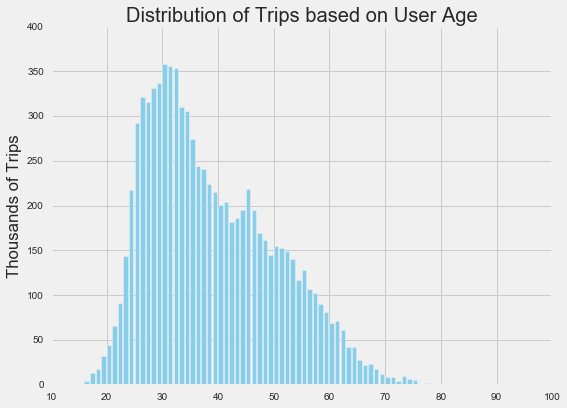

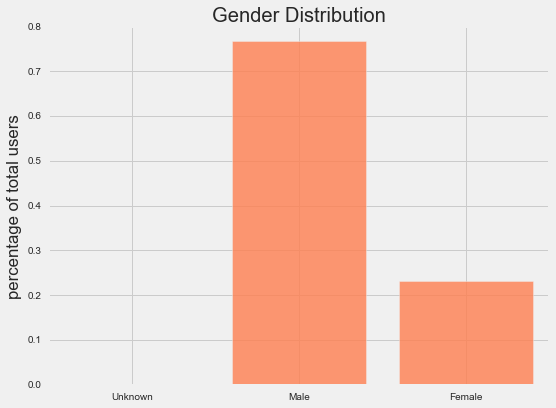

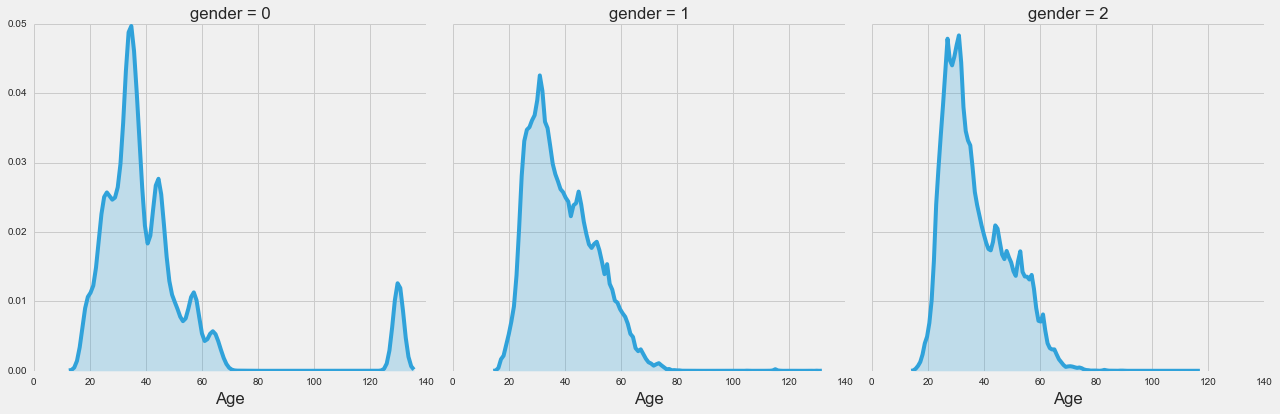

C:\tool\Anaconda2\lib\site-packages\ipykernel\__main__.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\tool\Anaconda2\lib\site-packages\ipykernel\__main__.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\tool\Anaconda2\lib\site-packages\ipykernel\__main__.py:115: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
C:\tool\Anaconda2\lib\site-packages\ipykernel\__main__.py:117: FutureWarning: Map.create_map is deprecated. Use Map.save instead
C:\tool\Anaconda2\lib\site-packages\ipykernel\__main__.py:1

In [2]:
import zipfile
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm
%matplotlib inline

filenames = []
for i in range(1,13):
    if i <10:
        filename = str(20150)+str(i)+'-citibike-tripdata.zip'
    else:
        filename = str(2015)+str(i)+'-citibike-tripdata.zip'
    filenames.append(filename)
print(filenames)

#for filename in filenames:
 #   zip_ref = zipfile.ZipFile(filename, 'r')
#  zip_ref.extractall()
#    zip_ref.close()

csv_files = [f.replace('zip','csv') for f in filenames]
df_set =[]
for f in csv_files:
    df_set.append(pd.read_csv(f))

#Basic Analysis: gender, age

related_cols_1 = ['usertype','birth year','gender']
df = df_set[0][related_cols_1]
for i in range(1,12):
    df_new = df_set[i][related_cols_1]
    df = pd.concat([df,df_new])

df_q1 = df[df['usertype']=='Subscriber'].dropna()


#Plot 1: distribution based on age
plt.style.use('fivethirtyeight')

df_q1['Age'] = 2015-df_q1['birth year'].astype(int)
groupby_age = df_q1.groupby('Age')['Age'].count()
under100 = groupby_age[groupby_age.index <= 100.0]

fig = plt.figure(figsize=(8,6))
plt.bar(under100.index, under100/1000,color='skyblue')
plt.ylabel('Thousands of Trips')
plt.title('Distribution of Trips based on User Age')
plt.show()
fig.savefig("Distribution based on age")

#Plot 2: distribution based on gender
groupby_gender = df_q1.groupby('gender')['gender'].count()/len(df_q1)
gender = ['Unknown',"Male","Female"]
fig = plt.figure(figsize=(8,6))
plt.bar(groupby_gender.index, groupby_gender,color='coral',align = 'center',alpha=0.8)
plt.xticks(groupby_gender.index,gender)
plt.ylabel("percentage of total users")
plt.title("Gender Distribution")
plt.show()
fig.savefig("Gender Distribution")

#Plot 3: distributions based on age and gender
g = sns.FacetGrid(df_q1, col="gender", size=6)
g.map(sns.kdeplot, "Age", shade=True)
sns.despine(bottom=True,left=True)
plt.show()
g.savefig("Distributions based on Age and Gender")

#Behaviors of Riders

related_cols_2 = ['usertype',"end station id","end station name","end station latitude","end station longitude"]
df_2 = df_set[0][related_cols_2]
for i in range(1,12):
    df_new = df_set[i][related_cols_2]
    df_2 = pd.concat([df_2,df_new])

#Non-subscribers    
df_q2 = df_2[df_2['usertype']!='Subscriber']
df_q2['end station id'].value_counts()
df_q2_rvdup = df_q2.drop_duplicates('end station id')
q2_groupby_id = df_q2.groupby('end station id')['end station id'].count()
def find_trips(esid):
    return q2_groupby_id.loc[esid]
df_q2_rvdup['Trips'] = df_q2_rvdup['end station id'].apply(find_trips)

#Subscribers
df_q3 = df_2[df_2['usertype']=='Subscriber']
df_q3['end station id'].value_counts()
df_q3_rvdup = df_q3.drop_duplicates('end station id')
q3_groupby_id = df_q3.groupby('end station id')['end station id'].count()
def find_trips(esid):
    return q3_groupby_id.loc[esid]
df_q3_rvdup['Trips'] = df_q3_rvdup['end station id'].apply(find_trips)

#Gussing: most non-subscribers are tourists, who tend to put aside bikes at attractions.Visualisation the drop-off stations.
#Graph 1: most popular desitinations of non-subscribers
norm_q2 = Normalize(df_q2_rvdup['Trips'].min(), df_q2_rvdup['Trips'].max())
# Get dark tileset from CartoBD (https://cartodb.com/basemaps)
tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'

end_station_map_q2 = folium.Map(location = [40.74, -73.99], width = 600, height = 800,
                               tiles = tileset,
                               attr = '© OpenStreetMap contributors, © CartoDB',
                               zoom_start = 12)

for index, row in df_q2_rvdup.iterrows():
    color = rgb2hex(cm.Blues(norm_q2(row['Trips'])))
    end_station_map_q2.circle_marker(location = [row['end station latitude'],
                                                row['end station longitude']],
                                    radius = row['Trips'] / 100,
                                    fill_color = color, line_color = color)
# Create the final html document
end_station_map_q2.create_map(path = 'non_subscribers_end_station_map.html

#Graph 2: most popular destinations of subscribers
norm_q3 = Normalize(df_q3_rvdup['Trips'].min(), df_q3_rvdup['Trips'].max())
# Get dark tileset from CartoBD (https://cartodb.com/basemaps)
tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'

end_station_map_q3 = folium.Map(location = [40.74, -73.99], width = 600, height = 800,
                               tiles = tileset,
                               attr = '© OpenStreetMap contributors, © CartoDB',
                               zoom_start = 12)

for index, row in df_q3_rvdup.iterrows():
    color = rgb2hex(cm.Oranges(norm_q3(row['Trips'])))
    end_station_map_q3.circle_marker(location = [row['end station latitude'],
                                                row['end station longitude']],
                                    radius = row['Trips'] / 1000,
                                    fill_color = color, line_color = color)
# Create the final html document
end_station_map_q3.create_map(path = 'subscribers_end_station_map.html')
